### Predict marathon time given (incomplete) shorter race times

In [1]:
%matplotlib inline
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import time, pickle

import numpy as np
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest

import tensorflow as tf

In [2]:
# Load data
file='data.csv'
raw_data = pd.read_csv(file, index_col=0)
raw_data.head()

,adjusted,age,bmi,cohort1,cohort2,cohort3,cohort4,endurancecat,endurancespeed,female,footwear,group,injury,k5_d,k5_di,k5_ti,k5_ti_adj,k5_tr,k10_d,k10_di,k10_ti,k10_ti_adj,k10_tr,m5_d,m5_di,m5_ti,m5_ti_adj,m5_tr,m10_d,m10_di,m10_ti,m10_ti_adj,m10_tr,mh_d,mh_di,mh_ti,mh_ti_adj,mh_tr,mf_d,mf_di,mf_ti,mf_ti_adj,mf_tr,max,sprint,tempo,typical,model1_time,model2_time
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,25.0,21.622116,NaN,NaN,NaN,NaN,1,2,1,2,2.0,1,NaN,NaN,NaN,NaN,NaN,10000.0,4.0,2798.0,2860.482422,2.0,NaN,NaN,NaN,NaN,NaN,16090.0,4.0,4612.0,4798.809082,2.0,21097.5,2.0,6320.0,6257.026367,2.0,NaN,NaN,NaN,NaN,NaN,47.0,1,0,30.0,NaN,NaN
2,1,41.0,23.905970,NaN,NaN,NaN,NaN,1,2,0,2,2.0,1,5000.0,3.0,1210.0,1210.000000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,4.0,5510.0,5654.475586,1.0,NaN,NaN,NaN,NaN,NaN,28.0,1,1,23.0,NaN,NaN
3,1,25.0,21.640728,NaN,NaN,NaN,NaN,2,3,0,2,2.0,1,5000.0,3.0,994.0,994.000061,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,4520.0,4520.000000,2.0,NaN,NaN,NaN,NaN,NaN,70.0,1,1,50.0,NaN,NaN
4,1,35.0,23.592323,1.0,NaN,NaN,NaN,2,5,0,2,1.0,2,5000.0,3.0,1075.0,1075.000000,1.0,10000.0,5.0,2135.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10295.0,10399.02832,1.0,60.0,1,1,50.0,NaN,NaN
5,1,34.0,22.706404,NaN,NaN,NaN,NaN,2,3,0,2,1.0,1,5000.0,3.0,1186.0,1186.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16090.0,4.0,4120.0,4268.437012,3.0,21097.5,3.0,5475.0,5475.000000,2.0,NaN,NaN,NaN,NaN,NaN,15.0,0,0,8.0,NaN,NaN


In [3]:
#raw_data.info()
#raw_data.describe()

## Explore data

In [4]:
data = raw_data.copy()

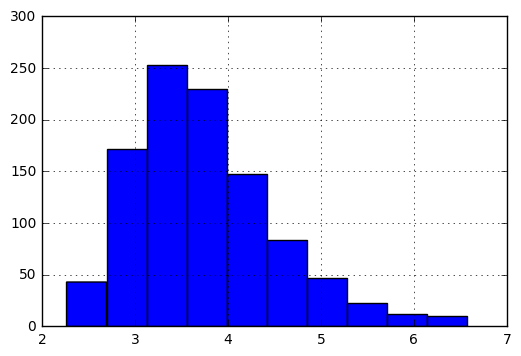

In [5]:
# Look at the range of times (in hours)
(data['mf_ti']/3600).hist(bins=10)

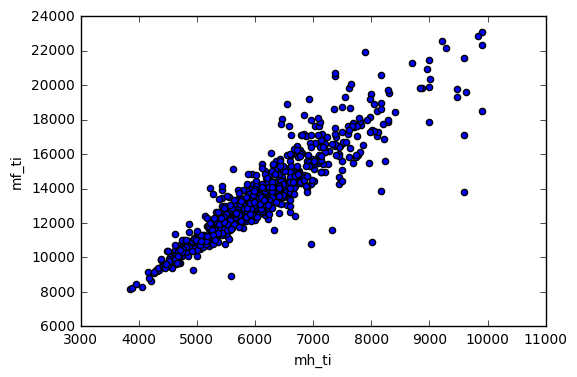

In [6]:
# Look at hm vs fm times
data.plot(x='mh_ti', y='mf_ti', kind='scatter')

In [198]:
# Look at all times vs fm times
def plot_manyx(df, x_cols, y_col, leg_loc=1):
    # Plot each (x_col,y) with colour c
    
    colors = cm.rainbow(np.linspace(0,1,len(x_cols)))
    ax = None
    
    for (x_col, color) in zip(x_cols, colors):
        if ax is None:
            ax = df.plot(x=x_col, y=y_col, kind='scatter', title=y_col, color=color)
        else:
            df.plot(x=x_col, y=y_col, kind='scatter', ax=ax, color=color)
    
    plt.legend(x_cols, loc=leg_loc)
    plt.show()
    



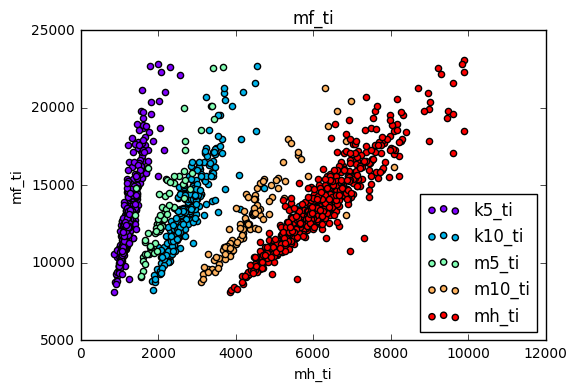

In [202]:
race_times = ['k5_ti', 'k10_ti', 'm5_ti', 'm10_ti', 'mh_ti', 'mf_ti']
plot_manyx(data, race_times[:-1], race_times[-1], leg_loc=4)

In [9]:
# ^^ Unsurprisingly, other race times are correlated with marathon time
# Probably this is just ~ same pace, confirmed below

In [10]:
# Look at numbers of race times
data[race_times].notnull().sum()

k5_ti     1387
k10_ti     946
m5_ti      313
m10_ti     357
mh_ti     1579
mf_ti     1022
dtype: int64

In [11]:
# Compute pace (in seconds/metre)
# *1600/60 to get mins/mile

race_dists = ['k5_d', 'k10_d', 'm5_d', 'm10_d', 'mh_d', 'mf_d']
race_paces = []

for race_time, race_dist in zip(race_times, race_dists):
    race_pace = race_dist[:-1] + 'pace'
    race_paces.append(race_pace)
    
    data[race_pace] = data[race_time] / data[race_dist]

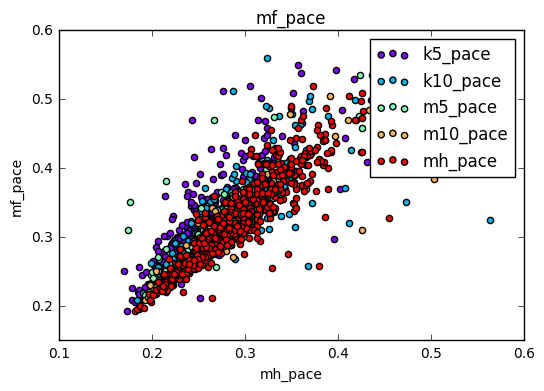

In [12]:
plot_manyx(data, race_paces[:-1], race_paces[-1])

In [13]:
# All plots ~aligned ==> an individual's pace for a shorter distance is similar to that for marathon

## Feature cleaning

In [14]:
#data[data['adjusted'] == 0][race_times].notnull().sum()

In [15]:
#data[data['adjusted'] == 0][race_times].head()

In [16]:
#data[data['cohort1'].isnull()][race_times].head()

In [17]:
# Filter by:
# adjusted == 1 -- adjusted to exclude very fast or very difficult races
# cohort1 == 1 -- otherwise no marathon time
data = data[data['adjusted']==1]
data = data[data['cohort1']==1]
data.head()

,adjusted,age,bmi,cohort1,cohort2,cohort3,cohort4,endurancecat,endurancespeed,female,footwear,group,injury,k5_d,k5_di,k5_ti,k5_ti_adj,k5_tr,k10_d,k10_di,k10_ti,k10_ti_adj,k10_tr,m5_d,m5_di,m5_ti,m5_ti_adj,m5_tr,m10_d,m10_di,m10_ti,m10_ti_adj,m10_tr,mh_d,mh_di,mh_ti,mh_ti_adj,mh_tr,mf_d,mf_di,mf_ti,mf_ti_adj,mf_tr,max,sprint,tempo,typical,model1_time,model2_time,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,1,35.0,23.592323,1.0,NaN,NaN,NaN,2,5,0,2,1.0,2,5000.0,3.0,1075.0,1075.000000,1.0,10000.0,5.0,2135.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10295.0,10399.028320,1.0,60.0,1,1,50.0,NaN,NaN,0.2150,0.2135,NaN,NaN,NaN,0.243986
7,1,33.0,22.518295,1.0,1.0,1.0,1.0,2,3,0,2,2.0,2,5000.0,4.0,1292.0,1299.988647,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,5760.0,5760.000000,2.0,42195.0,3.0,12292.0,12292.000000,2.0,50.0,0,0,40.0,NaN,NaN,0.2584,NaN,NaN,NaN,0.273018,0.291314
12,1,38.0,25.560312,1.0,NaN,NaN,NaN,1,2,0,2,3.0,1,NaN,NaN,NaN,NaN,NaN,10000.0,2.0,2580.0,2563.756348,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10980.0,11098.411133,1.0,65.0,0,1,50.0,206.163071,NaN,NaN,0.2580,NaN,NaN,NaN,0.260220
13,1,34.0,22.607931,1.0,1.0,NaN,NaN,1,2,0,2,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16090.0,1.0,3896.0,NaN,1.0,21097.5,3.0,4995.0,4995.000000,2.0,42195.0,3.0,10694.0,10694.000000,2.0,88.0,1,1,80.0,NaN,NaN,NaN,NaN,NaN,0.242138,0.236758,0.253442
14,1,39.0,24.974836,1.0,1.0,1.0,1.0,3,6,0,2,1.0,1,5000.0,4.0,1222.0,1229.144043,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,4.0,5884.0,6049.047852,1.0,42195.0,2.0,13452.0,13387.699219,1.0,51.0,0,1,40.0,NaN,NaN,0.2444,NaN,NaN,NaN,0.278896,0.318806


In [18]:
# Check performance of existing model1 -- uses 1 prior race
data_model1 = data[data['model1_time'].notnull()]
model1_mae = mean_absolute_error(data_model1.mf_ti/60, data_model1.model1_time)
print('Mean absolute error: %s minutes' % model1_mae)

Mean absolute error: 11.3689177646 minutes


In [19]:
# Model 2 -- uses 2 prior races
data_model2 = data[data['model2_time'].notnull()]
model2_mae = mean_absolute_error(data_model2.mf_ti/60, data_model2.model2_time)
print('Mean absolute error: %s minutes' % model2_mae)

Mean absolute error: 10.2873906453 minutes


In [20]:
# Drop unwanted columns: 
# endurancespeed, predicted results from other models
# Calculated data for 5k, 10k, half and full
# Drop 5 mile and 10 mile data (not enough)? Keep for now
data.drop(['k5_ti_adj', 'k10_ti_adj', 'm5_ti_adj', 'm10_ti_adj', 'mh_ti_adj', 'mf_ti_adj', \
           'endurancespeed', 'adjusted', 'cohort1', 'cohort2', 'cohort3', 'cohort4', \
          'model1_time', 'model2_time', 'group'], axis=1, inplace=True)
data.head()

,age,bmi,endurancecat,female,footwear,injury,k5_d,k5_di,k5_ti,k5_tr,k10_d,k10_di,k10_ti,k10_tr,m5_d,m5_di,m5_ti,m5_tr,m10_d,m10_di,m10_ti,m10_tr,mh_d,mh_di,mh_ti,mh_tr,mf_d,mf_di,mf_ti,mf_tr,max,sprint,tempo,typical,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,35.0,23.592323,2,0,2,2,5000.0,3.0,1075.0,1.0,10000.0,5.0,2135.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10295.0,1.0,60.0,1,1,50.0,0.2150,0.2135,NaN,NaN,NaN,0.243986
7,33.0,22.518295,2,0,2,2,5000.0,4.0,1292.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,5760.0,2.0,42195.0,3.0,12292.0,2.0,50.0,0,0,40.0,0.2584,NaN,NaN,NaN,0.273018,0.291314
12,38.0,25.560312,1,0,2,1,NaN,NaN,NaN,NaN,10000.0,2.0,2580.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10980.0,1.0,65.0,0,1,50.0,NaN,0.2580,NaN,NaN,NaN,0.260220
13,34.0,22.607931,1,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16090.0,1.0,3896.0,1.0,21097.5,3.0,4995.0,2.0,42195.0,3.0,10694.0,2.0,88.0,1,1,80.0,NaN,NaN,NaN,0.242138,0.236758,0.253442
14,39.0,24.974836,3,0,2,1,5000.0,4.0,1222.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,4.0,5884.0,1.0,42195.0,2.0,13452.0,1.0,51.0,0,1,40.0,0.2444,NaN,NaN,NaN,0.278896,0.318806


In [21]:
#data.dtypes

In [22]:
# Compute mean pace excluding marathon
data['mean_pace'] = data[race_paces[:-1]].mean(axis=1)
data.head()

,age,bmi,endurancecat,female,footwear,injury,k5_d,k5_di,k5_ti,k5_tr,k10_d,k10_di,k10_ti,k10_tr,m5_d,m5_di,m5_ti,m5_tr,m10_d,m10_di,m10_ti,m10_tr,mh_d,mh_di,mh_ti,mh_tr,mf_d,mf_di,mf_ti,mf_tr,max,sprint,tempo,typical,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace,mean_pace
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,35.0,23.592323,2,0,2,2,5000.0,3.0,1075.0,1.0,10000.0,5.0,2135.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10295.0,1.0,60.0,1,1,50.0,0.2150,0.2135,NaN,NaN,NaN,0.243986,0.214250
7,33.0,22.518295,2,0,2,2,5000.0,4.0,1292.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,5760.0,2.0,42195.0,3.0,12292.0,2.0,50.0,0,0,40.0,0.2584,NaN,NaN,NaN,0.273018,0.291314,0.265709
12,38.0,25.560312,1,0,2,1,NaN,NaN,NaN,NaN,10000.0,2.0,2580.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10980.0,1.0,65.0,0,1,50.0,NaN,0.2580,NaN,NaN,NaN,0.260220,0.258000
13,34.0,22.607931,1,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16090.0,1.0,3896.0,1.0,21097.5,3.0,4995.0,2.0,42195.0,3.0,10694.0,2.0,88.0,1,1,80.0,NaN,NaN,NaN,0.242138,0.236758,0.253442,0.239448
14,39.0,24.974836,3,0,2,1,5000.0,4.0,1222.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,4.0,5884.0,1.0,42195.0,2.0,13452.0,1.0,51.0,0,1,40.0,0.2444,NaN,NaN,NaN,0.278896,0.318806,0.261648


In [23]:
# Drop any more fields
#data.drop(['k5_d', 'k5_ti', 'k10_d', 'k10_ti', 'mh_d', 'mh_ti', 'mf_d', 'mf_ti'], axis=1, inplace=True)
#data.drop(['k5_ti', 'k10_ti', 'mh_ti', 'mf_ti'], axis=1, inplace=True)

In [24]:
# Categorise feature cols
personal_cols = ['age', 'bmi', 'endurancecat', 'female', 'footwear', 'injury']
# about the individual

running_cols = ['max', 'sprint', 'tempo', 'typical']
# About running in general

race_difficulties = ['k5_di', 'k10_di', 'm5_di', 'm10_di', 'mh_di', 'mf_di']
race_fitness = ['k5_tr', 'k10_tr', 'm5_tr', 'm10_tr', 'mh_tr', 'mf_tr']
# Already have race_dists, _times, _paces plus 'mean_pace'

In [25]:
# Also compute mean dist, difficulty and fitness
data['mean_dist'] = data[race_dists[:-1]].mean(axis=1)
data['mean_difficulty'] = data[race_difficulties[:-1]].mean(axis=1)
data['mean_fitness'] = data[race_fitness[:-1]].mean(axis=1)
data.head()

,age,bmi,endurancecat,female,footwear,injury,k5_d,k5_di,k5_ti,k5_tr,k10_d,k10_di,k10_ti,k10_tr,m5_d,m5_di,m5_ti,m5_tr,m10_d,m10_di,m10_ti,m10_tr,mh_d,mh_di,mh_ti,mh_tr,mf_d,mf_di,mf_ti,mf_tr,max,sprint,tempo,typical,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace,mean_pace,mean_dist,mean_difficulty,mean_fitness
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,35.0,23.592323,2,0,2,2,5000.0,3.0,1075.0,1.0,10000.0,5.0,2135.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10295.0,1.0,60.0,1,1,50.0,0.2150,0.2135,NaN,NaN,NaN,0.243986,0.214250,7500.00,4.0,1.0
7,33.0,22.518295,2,0,2,2,5000.0,4.0,1292.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,5760.0,2.0,42195.0,3.0,12292.0,2.0,50.0,0,0,40.0,0.2584,NaN,NaN,NaN,0.273018,0.291314,0.265709,13048.75,3.5,2.5
12,38.0,25.560312,1,0,2,1,NaN,NaN,NaN,NaN,10000.0,2.0,2580.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10980.0,1.0,65.0,0,1,50.0,NaN,0.2580,NaN,NaN,NaN,0.260220,0.258000,10000.00,2.0,3.0
13,34.0,22.607931,1,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16090.0,1.0,3896.0,1.0,21097.5,3.0,4995.0,2.0,42195.0,3.0,10694.0,2.0,88.0,1,1,80.0,NaN,NaN,NaN,0.242138,0.236758,0.253442,0.239448,18593.75,2.0,1.5
14,39.0,24.974836,3,0,2,1,5000.0,4.0,1222.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,4.0,5884.0,1.0,42195.0,2.0,13452.0,1.0,51.0,0,1,40.0,0.2444,NaN,NaN,NaN,0.278896,0.318806,0.261648,13048.75,4.0,1.0


In [26]:
data[race_paces + ['mean_pace']].head()

,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace,mean_pace
id,,,,,,,
4,0.2150,0.2135,NaN,NaN,NaN,0.243986,0.214250
7,0.2584,NaN,NaN,NaN,0.273018,0.291314,0.265709
12,NaN,0.2580,NaN,NaN,NaN,0.260220,0.258000
13,NaN,NaN,NaN,0.242138,0.236758,0.253442,0.239448
14,0.2444,NaN,NaN,NaN,0.278896,0.318806,0.261648


In [27]:
data[race_paces + ['mean_pace']].describe()

,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace,mean_pace
count,397.000000,268.000000,67.000000,96.000000,654.000000,929.000000,929.000000
mean,0.254702,0.274658,0.269083,0.276520,0.288857,0.318234,0.277341
std,0.046645,0.054017,0.062661,0.057551,0.051238,0.062182,0.052038
min,0.170400,0.184000,0.175016,0.192977,0.182391,0.193198,0.175016
25%,0.224200,0.237925,0.222809,0.237415,0.254118,0.274440,0.241100
50%,0.247000,0.262900,0.253574,0.267526,0.282569,0.308567,0.268275
75%,0.272200,0.299400,0.298322,0.293474,0.316424,0.351226,0.304484
max,0.515000,0.564000,0.457054,0.503418,0.469534,0.547458,0.515000


In [28]:
data[race_paces + ['mean_pace']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 4 to 2171
Data columns (total 7 columns):
k5_pace      397 non-null float64
k10_pace     268 non-null float64
m5_pace      67 non-null float64
m10_pace     96 non-null float64
mh_pace      654 non-null float64
mf_pace      929 non-null float64
mean_pace    929 non-null float64
dtypes: float64(7)
memory usage: 58.1 KB


## Train quick LR model
Predict marathon pace from mean pace

In [29]:
# Split into train/test/holdout
seed=1

holdout_frac = 0.1
data_traintest, data_holdout = train_test_split(data, test_size=holdout_frac, random_state=seed)

test_frac = 0.2
data_train, data_test = train_test_split(data_traintest, test_size=test_frac, random_state=seed)

In [30]:
# Get x and y from the df
def get_xy(df, y_col, x_cols=None):
    # Return x and y arrays from df
    if x_cols is None:
        x = df.drop(y_col, axis=1).values
    else:
        x = df[x_cols].values
        
    y = df[y_col].values
    
    return (x,y)

In [31]:
# Use only mean_pace column to predict
x_train, y_train = get_xy(data_train, 'mf_pace', 'mean_pace')
x_test, y_test = get_xy(data_test, 'mf_pace', 'mean_pace')
print(x_train.shape, y_train.shape)
print(x_test.shape)

(668,) (668,)
(168,)


In [32]:
# Reshape x since only one feature
x_train = x_train.reshape((-1,1))
x_test = x_test.reshape((-1,1))

print(x_train.shape, x_test.shape)

(668, 1) (168, 1)


In [33]:
# Train model
ridge_model = Ridge(random_state=seed)
ridge_model.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [34]:
# Predict and get score
y_train_pred = ridge_model.predict(x_train)
y_test_pred = ridge_model.predict(x_test)

y_train_score = ridge_model.score(x_train, y_train)
y_test_score = ridge_model.score(x_test, y_test)

In [35]:
print(y_train_score)
print(y_test_score)

0.682539535842
0.67645338922


In [36]:
# Look at predictions
data_test['mf_pace_pred'] = y_test_pred
data_test['mf_ti_pred'] = data_test['mf_pace_pred']*data_test['mf_d']
data_test['mf_ti_pred_error'] = data_test['mf_ti_pred'] - data_test['mf_ti']
data_test.head()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

,age,bmi,endurancecat,female,footwear,injury,k5_d,k5_di,k5_ti,k5_tr,k10_d,k10_di,k10_ti,k10_tr,m5_d,m5_di,m5_ti,m5_tr,m10_d,m10_di,m10_ti,m10_tr,mh_d,mh_di,mh_ti,mh_tr,mf_d,mf_di,mf_ti,mf_tr,max,sprint,tempo,typical,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace,mean_pace,mean_dist,mean_difficulty,mean_fitness,mf_pace_pred,mf_ti_pred,mf_ti_pred_error
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1740,32.0,24.489796,3,0,2,1,5000.0,3.0,985.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,2.0,4528.0,1.0,42195.0,2.0,9787.0,1.0,83.0,0,1,65.0,0.197,NaN,NaN,NaN,0.214623,0.231947,0.205811,13048.75,2.5,1.5,0.270274,11404.232173,1617.232173
860,49.0,20.899574,1,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,5840.0,2.0,42195.0,3.0,12363.0,2.0,67.0,1,0,45.0,NaN,NaN,NaN,NaN,0.276810,0.292997,0.276810,21097.50,3.0,2.0,0.318164,13424.930433,1061.930433
216,38.0,20.419033,2,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8045.0,2.0,2135.0,2.0,NaN,NaN,NaN,NaN,21097.5,3.0,5868.0,2.0,42195.0,2.0,13120.0,1.0,62.0,1,1,55.0,NaN,NaN,0.265382,NaN,0.278137,0.310937,0.271760,14571.25,2.5,2.0,0.314758,13281.192913,161.192913
1345,37.0,24.526159,2,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,5292.0,2.0,42195.0,3.0,11262.0,2.0,75.0,0,1,60.0,NaN,NaN,NaN,NaN,0.250835,0.266904,0.250835,21097.50,3.0,2.0,0.300644,12685.665182,1423.665182
155,29.0,27.197418,2,1,2,2,5000.0,4.0,1660.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,2.0,8007.0,2.0,42195.0,3.0,17341.0,1.0,44.0,0,0,35.0,0.332,NaN,NaN,NaN,0.379524,0.410973,0.355762,13048.75,3.0,1.5,0.371418,15671.979773,-1669.020227


In [37]:
mf_ti_mae_test = mean_absolute_error(data_test.mf_ti, data_test.mf_ti_pred)
print('Mean absolute error: %s minutes' % (mf_ti_mae_test/60))

Mean absolute error: 20.1214940698 minutes


In [38]:
# ^^ Not amazing but not a bad start. Existing model is 10-11 mins.

In [39]:
# Look at coefficients
print(ridge_model.coef_)
print(ridge_model.intercept_)

[ 0.67451209]
0.131452286409


### Try predicting only with half marathon time

In [40]:
# Lazily keep same train/test split, just drop rows without half marathon time
data_train_mh = data_train[data_train['mh_ti'].notnull()]
print('Train data reduced from %s to %s' % (len(data_train), len(data_train_mh)))

data_test_mh = data_test[data_test['mh_ti'].notnull()]
print('Test data reduced from %s to %s' % (len(data_test), len(data_test_mh)))

Train data reduced from 668 to 469
Test data reduced from 168 to 120


In [41]:
# Use only mh pace column to predict
x_train_mh, y_train_mh = get_xy(data_train_mh, 'mf_pace', 'mh_pace')
x_test_mh, y_test_mh = get_xy(data_test_mh, 'mf_pace', 'mh_pace')
print(x_train_mh.shape, y_train_mh.shape)
print(x_test_mh.shape)

(469,) (469,)
(120,)


In [42]:
# Reshape x since only one feature
x_train_mh = x_train_mh.reshape((-1,1))
x_test_mh = x_test_mh.reshape((-1,1))

print(x_train_mh.shape, x_test_mh.shape)

(469, 1) (120, 1)


In [43]:
# Train model
ridge_model_mh = Ridge(random_state=seed)
ridge_model_mh.fit(x_train_mh, y_train_mh)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

In [44]:
# Predict and get score
y_train_pred_mh = ridge_model.predict(x_train_mh)
y_test_pred_mh = ridge_model.predict(x_test_mh)

y_train_score_mh = ridge_model.score(x_train_mh, y_train_mh)
y_test_score_mh = ridge_model.score(x_test_mh, y_test_mh)

In [45]:
# Look at predictions
data_test_mh['mf_pace_pred'] = y_test_pred_mh
data_test_mh['mf_ti_pred'] = data_test_mh['mf_pace_pred']*data_test_mh['mf_d']
data_test_mh['mf_ti_pred_error'] = data_test_mh['mf_ti_pred'] - data_test_mh['mf_ti']

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [46]:
mf_ti_mae_test_mh = mean_absolute_error(data_test_mh.mf_ti, data_test_mh.mf_ti_pred)
print('Mean absolute error: %s minutes' % (mf_ti_mae_test_mh/60))

Mean absolute error: 20.3484918876 minutes


In [47]:
# ^^ No different from mean model, interesting

In [48]:
# Look at coefficients
print(ridge_model_mh.coef_)
print(ridge_model_mh.intercept_)

[ 0.60354937]
0.146236722848


### Feature processing -- using mean of all prior races

In [49]:
clean_data = data.copy()
clean_data.head()

,age,bmi,endurancecat,female,footwear,injury,k5_d,k5_di,k5_ti,k5_tr,k10_d,k10_di,k10_ti,k10_tr,m5_d,m5_di,m5_ti,m5_tr,m10_d,m10_di,m10_ti,m10_tr,mh_d,mh_di,mh_ti,mh_tr,mf_d,mf_di,mf_ti,mf_tr,max,sprint,tempo,typical,k5_pace,k10_pace,m5_pace,m10_pace,mh_pace,mf_pace,mean_pace,mean_dist,mean_difficulty,mean_fitness
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,35.0,23.592323,2,0,2,2,5000.0,3.0,1075.0,1.0,10000.0,5.0,2135.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10295.0,1.0,60.0,1,1,50.0,0.2150,0.2135,NaN,NaN,NaN,0.243986,0.214250,7500.00,4.0,1.0
7,33.0,22.518295,2,0,2,2,5000.0,4.0,1292.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,3.0,5760.0,2.0,42195.0,3.0,12292.0,2.0,50.0,0,0,40.0,0.2584,NaN,NaN,NaN,0.273018,0.291314,0.265709,13048.75,3.5,2.5
12,38.0,25.560312,1,0,2,1,NaN,NaN,NaN,NaN,10000.0,2.0,2580.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42195.0,4.0,10980.0,1.0,65.0,0,1,50.0,NaN,0.2580,NaN,NaN,NaN,0.260220,0.258000,10000.00,2.0,3.0
13,34.0,22.607931,1,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16090.0,1.0,3896.0,1.0,21097.5,3.0,4995.0,2.0,42195.0,3.0,10694.0,2.0,88.0,1,1,80.0,NaN,NaN,NaN,0.242138,0.236758,0.253442,0.239448,18593.75,2.0,1.5
14,39.0,24.974836,3,0,2,1,5000.0,4.0,1222.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21097.5,4.0,5884.0,1.0,42195.0,2.0,13452.0,1.0,51.0,0,1,40.0,0.2444,NaN,NaN,NaN,0.278896,0.318806,0.261648,13048.75,4.0,1.0


In [50]:
# Rename some cols
clean_data = clean_data.rename(columns={'mf_d':'mf_dist', 'mf_di':'mf_difficulty', 'mf_tr':'mf_fitness'})

In [51]:
# Get mf_dist (in metres)
mf_dist = clean_data['mf_dist'].head(1).values[0]
mf_dist

42195.0

In [52]:
# Group cols
numerical_cols = ['mean_pace']
numerical_cols_tonormalize = ['age', 'bmi', 'max', 'typical', 'mean_difficulty', 'mf_difficulty', 'mean_fitness', 'mf_fitness', 'mean_dist']
categorical_cols = ['endurancecat', 'footwear', 'injury']
binary_cols = ['female', 'sprint', 'tempo']

label_col = 'mf_pace'

all_cols = binary_cols + categorical_cols + numerical_cols_tonormalize + numerical_cols + [label_col]


In [53]:
# Drop unwanted cols
clean_data = clean_data[all_cols]
clean_data.head()

,female,sprint,tempo,endurancecat,footwear,injury,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,mf_pace
id,,,,,,,,,,,,,,,,,
4,0,1,1,2,2,2,35.0,23.592323,60.0,50.0,4.0,4.0,1.0,1.0,7500.00,0.214250,0.243986
7,0,0,0,2,2,2,33.0,22.518295,50.0,40.0,3.5,3.0,2.5,2.0,13048.75,0.265709,0.291314
12,0,0,1,1,2,1,38.0,25.560312,65.0,50.0,2.0,4.0,3.0,1.0,10000.00,0.258000,0.260220
13,0,1,1,1,2,1,34.0,22.607931,88.0,80.0,2.0,3.0,1.5,2.0,18593.75,0.239448,0.253442
14,0,0,1,3,2,1,39.0,24.974836,51.0,40.0,4.0,2.0,1.0,1.0,13048.75,0.261648,0.318806


In [54]:
# 1-hot encode categorical features
clean_data = pd.get_dummies(clean_data, columns = categorical_cols, drop_first=False)
clean_data.head()

,female,sprint,tempo,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,mf_pace,endurancecat_1,endurancecat_2,endurancecat_3,endurancecat_4,footwear_1,footwear_2,footwear_3,injury_1,injury_2,injury_3
id,,,,,,,,,,,,,,,,,,,,,,,,
4,0,1,1,35.0,23.592323,60.0,50.0,4.0,4.0,1.0,1.0,7500.00,0.214250,0.243986,0,1,0,0,0,1,0,0,1,0
7,0,0,0,33.0,22.518295,50.0,40.0,3.5,3.0,2.5,2.0,13048.75,0.265709,0.291314,0,1,0,0,0,1,0,0,1,0
12,0,0,1,38.0,25.560312,65.0,50.0,2.0,4.0,3.0,1.0,10000.00,0.258000,0.260220,1,0,0,0,0,1,0,1,0,0
13,0,1,1,34.0,22.607931,88.0,80.0,2.0,3.0,1.5,2.0,18593.75,0.239448,0.253442,1,0,0,0,0,1,0,1,0,0
14,0,0,1,39.0,24.974836,51.0,40.0,4.0,2.0,1.0,1.0,13048.75,0.261648,0.318806,0,0,1,0,0,1,0,1,0,0


In [55]:
# List of feature cols
feature_cols = list(clean_data.columns)
feature_cols.remove(label_col)

In [56]:
# Split into train/test/holdout again (same split but new feature cols)
seed=1

holdout_frac = 0.1
data_traintest, data_holdout = train_test_split(clean_data, test_size=holdout_frac, random_state=seed)

test_frac = 0.2
data_train, data_test = train_test_split(data_traintest, test_size=test_frac, random_state=seed)

In [57]:
# Scale numerical cols
scaler = MinMaxScaler()
scaler.fit(data_train[numerical_cols_tonormalize])

data_train[numerical_cols_tonormalize] = scaler.transform(data_train[numerical_cols_tonormalize])
data_test[numerical_cols_tonormalize] = scaler.transform(data_test[numerical_cols_tonormalize])
data_holdout[numerical_cols_tonormalize] = scaler.transform(data_holdout[numerical_cols_tonormalize])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.h

In [58]:
data_test.head()

,female,sprint,tempo,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,mf_pace,endurancecat_1,endurancecat_2,endurancecat_3,endurancecat_4,footwear_1,footwear_2,footwear_3,injury_1,injury_2,injury_3
id,,,,,,,,,,,,,,,,,,,,,,,,
1740,0,0,1,0.24,0.229499,0.566667,0.500000,0.333333,0.0,0.166667,0.000000,0.50000,0.205811,0.231947,0,0,1,0,0,1,0,1,0,0
860,1,1,0,0.58,0.107610,0.433333,0.318182,0.500000,0.5,0.333333,0.333333,1.00000,0.276810,0.292997,1,0,0,0,0,1,0,0,1,0
216,1,1,1,0.36,0.091295,0.391667,0.409091,0.333333,0.0,0.333333,0.000000,0.59458,0.271760,0.310937,0,1,0,0,0,1,0,0,1,0
1345,0,0,1,0.34,0.230734,0.500000,0.454545,0.500000,0.5,0.333333,0.333333,1.00000,0.250835,0.266904,0,1,0,0,0,1,0,1,0,0
155,1,0,0,0.18,0.321424,0.241667,0.227273,0.500000,0.5,0.166667,0.000000,0.50000,0.355762,0.410973,0,1,0,0,0,1,0,0,1,0


In [59]:
# Look at feature importances based on correlations
f_F, f_pval = f_regression(data_train[feature_cols], data_train[label_col])
f_regr_train = pd.DataFrame({'feature': feature_cols, 'F': f_F, 'pval': f_pval})
f_regr_train['significant_005'] = f_regr_train.pval.apply(lambda x: 1 if x<0.05 else 0)
f_regr_train.sort_values('pval', ascending=True).head(100)

,F,feature,pval,significant_005
12,2298.224153,mean_pace,4.127171e-218,1
6,388.973016,typical,1.524555e-68,1
5,303.866097,max,2.412889e-56,1
4,140.733426,bmi,1.386734e-29,1
2,89.314375,tempo,5.614363e-20,1
1,82.600946,sprint,1.135335e-18,1
0,72.969447,female,8.940007e-17,1
10,43.181171,mf_fitness,1.007015e-10,1
9,21.176882,mean_fitness,5.014956e-06,1
3,15.550096,age,8.885771e-05,1


In [60]:
# ^^ a lot are significant, obviously mean pace is most strongly correlated

### Train models with all features

In [61]:
x_train, y_train = get_xy(data_train, label_col, feature_cols)
x_test, y_test = get_xy(data_test, label_col, feature_cols)
print(x_train.shape, y_train.shape)
print(x_test.shape)

(668, 23) (668,)
(168, 23)


In [62]:
def train_model(x, y, x_t, y_t, model_name, model_func, model_params):
    
    print('\n' + model_name)
    
    model_cv = GridSearchCV(model_func, model_params)
    
    # Train model
    t0 = time.time()
    model_cv.fit(x, y)
    print('Model trained in {:.1f} seconds'.format(time.time() - t0))
    
    # Choose best model and print params
    model = model_cv.best_estimator_
    print(model_cv.best_params_)

    # Predict and get score
    y_train_pred = model.predict(x)
    y_test_pred = model.predict(x_t)

    y_train_score = model.score(x, y)
    y_test_score = model.score(x_t, y_t)
    
    # Print scores
    print('Train score: {:.2f}'.format(y_train_score))
    print('Test score: {:.2f}'.format(y_test_score))

    # Print MAE
    mae_train = mean_absolute_error(y, y_train_pred)
    mae_test = mean_absolute_error(y_t, y_test_pred)
    print('Mean absolute train error: {:.2f} minutes'.format(mae_train*mf_dist*1.0/60))
    print('Mean absolute test error: {:.2f} minutes'.format(mae_test*mf_dist*1.0/60))
    
    return model

In [63]:
# Models and params
models = {'ridge': Ridge(random_state=seed), \
          'lasso': Lasso(random_state=seed), \
          'tree': DecisionTreeRegressor(random_state=seed)}#, \
          #'forest': RandomForestRegressor(random_state=seed, n_jobs=1)}

params = {'ridge': {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 500, 1000]}, \
          'tree': {'max_depth': [2,4,6,8,10,12,None], 'min_samples_leaf': [1,2,5,10], 'criterion': ['mse', 'mae']}}

params['lasso'] = params['ridge'].copy()
#params['forest'] = params['tree'].copy()
#params['forest']['n_estimators'] = [5,10]

In [135]:
# Train all models
run_train=False
if run_train:
    trained_models = {}

    for model_name, model_func in models.items():
        trained_model = train_model(x_train, y_train, x_test, y_test, model_name, model_func, params[model_name])
        trained_models[model_name] = trained_model
    
    # Save trained models
    pickle.dump(trained_models, open('trained_models.pkl', 'wb'))

else:
    trained_models = pickle.load(open('trained_models.pkl', 'rb'))


ridge
Model trained in 0.3 seconds
{'max_iter': 100, 'alpha': 0.0001}
Train score: 0.85
Test score: 0.88
Mean absolute train error: 11.23 minutes
Mean absolute test error: 10.67 minutes

tree
Model trained in 1.4 seconds
{'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'mae'}
Train score: 0.86
Test score: 0.84
Mean absolute train error: 9.98 minutes
Mean absolute test error: 12.61 minutes

lasso
Model trained in 0.2 seconds
{'max_iter': 100, 'alpha': 0.0001}
Train score: 0.85
Test score: 0.88
Mean absolute train error: 11.43 minutes
Mean absolute test error: 10.91 minutes


In [65]:
# Look at features for best linear model
linear_model = trained_models['ridge']

In [66]:
coefs = linear_model.coef_

In [67]:
coefs_df = pd.DataFrame(coefs.reshape((1,len(coefs))))
coefs_df.columns = feature_cols
coefs_df.head()

,female,sprint,tempo,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,endurancecat_1,endurancecat_2,endurancecat_3,endurancecat_4,footwear_1,footwear_2,footwear_3,injury_1,injury_2,injury_3
0,0.002055,-0.002859,-0.004044,0.00923,0.041534,0.001071,-0.062847,0.019276,-0.006645,-0.031253,0.03443,-0.02628,0.933105,0.001001,0.00082,0.001312,-0.003133,-0.004387,-0.004718,0.009106,-0.001482,-0.000267,0.00175


In [68]:
coefs_T = coefs_df.T
coefs_T.columns = ['coefficient']
coefs_T.head()

,coefficient
female,0.002055
sprint,-0.002859
tempo,-0.004044
age,0.009230
bmi,0.041534


In [69]:
# Join to f_regr
feature_importance = f_regr_train.join(coefs_T, on='feature')
sign_level = 0.05

feature_importance['influence'] = feature_importance['pval'].apply(lambda x: 1 if x<sign_level else 0)
feature_importance['influence'] = feature_importance['influence']*feature_importance['coefficient']
feature_importance['influence'] = feature_importance['influence'].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)

feature_importance['signed_F'] = feature_importance['influence'].apply(lambda x: 1 if x>= 0 else -1)
feature_importance['signed_F'] = feature_importance['F']*feature_importance['signed_F']
feature_importance.drop('F', axis=1, inplace=True)
feature_importance.drop('significant_005', axis=1, inplace=True)


feature_importance.sort_values('signed_F', ascending=False).head(100)


,feature,pval,coefficient,influence,signed_F
12,mean_pace,4.127171e-218,0.933105,1,2298.224153
5,max,2.412889e-56,0.001071,1,303.866097
4,bmi,1.386734e-29,0.041534,1,140.733426
0,female,8.940007e-17,0.002055,1,72.969447
10,mf_fitness,1.007015e-10,0.034430,1,43.181171
3,age,8.885771e-05,0.009230,1,15.550096
22,injury_3,5.339117e-04,0.001750,1,12.111131
13,endurancecat_1,3.391778e-03,0.001001,1,8.645818
15,endurancecat_3,1.283946e-02,0.001312,1,6.224652
19,footwear_3,6.671073e-02,0.009106,0,3.373192


In [70]:
data_test_ = data_test.copy()

In [71]:
# Look at predictions -- in minutes and min/mile
data_test_['mf_pace_pred'] = linear_model.predict(x_test)
data_test_['mf_time_mins'] = data_test_['mf_pace']*mf_dist*1.0/60
data_test_['mf_time_pred_mins'] = data_test_['mf_pace_pred']*mf_dist*1.0/60

data_test_['mf_time_error_mins'] = data_test_['mf_time_pred_mins'] - data_test_['mf_time_mins']

# Pace in min/mile
data_test_['mf_pace_minmile'] = data_test_['mf_pace']*1000*1.6/60
data_test_['mf_pace_pred_minmile'] = data_test_['mf_pace_pred']*1000*1.6/60

data_test_.sort_values(by='mf_time_error_mins', ascending=True).head()

,female,sprint,tempo,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,mf_pace,endurancecat_1,endurancecat_2,endurancecat_3,endurancecat_4,footwear_1,footwear_2,footwear_3,injury_1,injury_2,injury_3,mf_pace_pred,mf_time_mins,mf_time_pred_mins,mf_time_error_mins,mf_pace_minmile,mf_pace_pred_minmile
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1162,0,0,0,0.36,0.328696,0.025000,0.045455,0.500000,1.0,0.666667,0.333333,0.000000,0.264000,0.427207,0,1,0,0,0,1,0,0,0,1,0.334450,300.433333,235.201726,-65.231608,11.392187,8.918658
1560,1,0,1,0.28,0.072259,0.291667,0.272727,0.500000,0.5,0.333333,0.333333,0.000000,0.280400,0.419481,0,1,0,0,0,1,0,1,0,0,0.332884,295.000000,234.100803,-60.899197,11.186159,8.876912
1574,0,1,1,0.16,0.146150,0.141667,0.136364,0.500000,1.0,0.500000,0.000000,0.655304,0.322747,0.407276,0,1,0,0,0,1,0,1,0,0,0.340626,286.416667,239.544911,-46.871755,10.860686,9.083348
1475,1,1,1,0.34,0.350654,0.208333,0.181818,0.333333,0.5,0.500000,0.333333,0.500000,0.340960,0.458016,1,0,0,0,0,0,1,0,0,1,0.399950,322.100000,281.264967,-40.835033,12.213769,10.665338
1812,0,1,1,0.24,0.189312,0.275000,0.272727,0.166667,0.5,0.000000,0.000000,0.344463,0.268895,0.362839,0,1,0,0,1,0,0,0,1,0,0.306719,255.166667,215.700165,-39.466501,9.675712,8.179174


In [72]:
# Faster than expected
data_test_.sort_values(by='mf_time_error_mins', ascending=False).head()

,female,sprint,tempo,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,mf_pace,endurancecat_1,endurancecat_2,endurancecat_3,endurancecat_4,footwear_1,footwear_2,footwear_3,injury_1,injury_2,injury_3,mf_pace_pred,mf_time_mins,mf_time_pred_mins,mf_time_error_mins,mf_pace_minmile,mf_pace_pred_minmile
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
545,0,0,1,0.50,0.207765,0.208333,0.181818,0.333333,0.5,0.666667,0.000000,0.344463,0.326185,0.296481,0,1,0,0,0,1,0,1,0,0,0.352675,208.500000,248.018814,39.518814,7.906150,9.404671
220,0,0,0,0.46,0.064876,0.350000,0.272727,0.000000,0.0,0.000000,0.000000,0.500000,0.284499,0.275435,1,0,0,0,0,1,0,1,0,0,0.319783,193.700000,224.887421,31.187421,7.344946,8.527548
225,1,1,0,0.30,0.252428,0.166667,0.136364,0.500000,1.0,0.000000,0.000000,0.155304,0.302400,0.342529,1,0,0,0,0,0,1,1,0,0,0.376244,240.883333,264.593711,23.710378,9.134100,10.033178
1623,0,0,0,0.46,0.183950,0.250000,0.272727,0.500000,0.5,0.333333,0.333333,0.000000,0.210000,0.241735,0,1,0,0,0,1,0,1,0,0,0.275439,170.000000,193.702636,23.702636,6.446261,7.345046
1649,1,0,0,0.54,0.020162,0.541667,0.363636,0.333333,1.0,0.333333,0.333333,0.344463,0.285149,0.288755,0,1,0,0,0,1,0,0,1,0,0.321777,203.066667,226.289859,23.223192,7.700122,8.580727


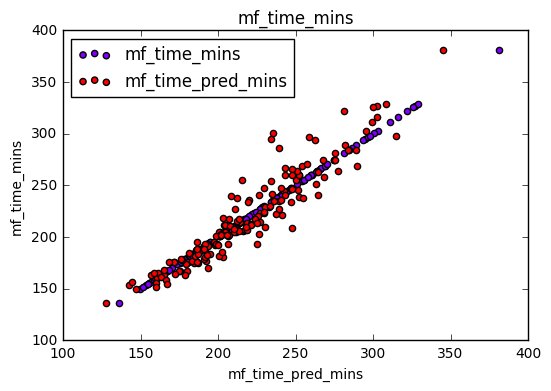

In [206]:
# Look at fm times / _pred
plot_manyx(data_test_, ['mf_time_mins', 'mf_time_pred_mins'], 'mf_time_mins', leg_loc=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ff88a4fd0>]], dtype=object)

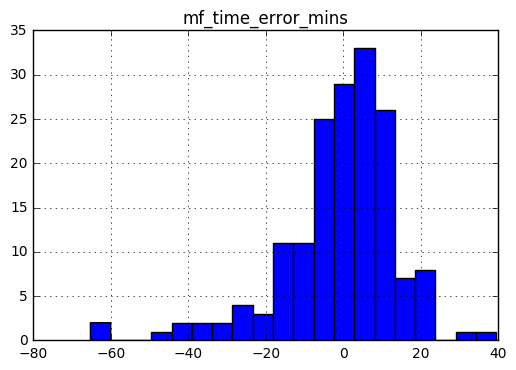

In [74]:
# Look at errors
data_test_.hist(column='mf_time_error_mins', bins=20)

In [75]:
# ^^ two types of errors:
# 1. negative: actual time slower than predicted: fat tail: bonking, hard to predict
# 2. positive: actual time slightly faster: well paced runners

### Look at polynomial feature combinations

In [136]:
# Get polynomial features using train data
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

x_train_ = poly.fit_transform(x_train)
x_train_.shape

(668, 299)

In [137]:
poly_feature_cols = list(poly.get_feature_names(feature_cols))

In [138]:
data_train_poly = pd.DataFrame(x_train_)
data_train_poly.columns = poly_feature_cols
data_train_poly[label_col] = y_train
data_train_poly.head()

,female,sprint,tempo,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,endurancecat_1,endurancecat_2,endurancecat_3,endurancecat_4,footwear_1,footwear_2,footwear_3,injury_1,injury_2,injury_3,female^2,female sprint,female tempo,female age,female bmi,female max,female typical,female mean_difficulty,female mf_difficulty,female mean_fitness,female mf_fitness,female mean_dist,female mean_pace,female endurancecat_1,female endurancecat_2,female endurancecat_3,female endurancecat_4,female footwear_1,female footwear_2,female footwear_3,female injury_1,female injury_2,female injury_3,sprint^2,sprint tempo,sprint age,sprint bmi,sprint max,sprint typical,sprint mean_difficulty,sprint mf_difficulty,sprint mean_fitness,sprint mf_fitness,sprint mean_dist,sprint mean_pace,sprint endurancecat_1,sprint endurancecat_2,sprint endurancecat_3,sprint endurancecat_4,sprint footwear_1,sprint footwear_2,sprint footwear_3,sprint injury_1,sprint injury_2,sprint injury_3,tempo^2,tempo age,tempo bmi,tempo max,tempo typical,tempo mean_difficulty,tempo mf_difficulty,tempo mean_fitness,tempo mf_fitness,tempo mean_dist,tempo mean_pace,tempo endurancecat_1,tempo endurancecat_2,tempo endurancecat_3,tempo endurancecat_4,tempo footwear_1,tempo footwear_2,tempo footwear_3,tempo injury_1,tempo injury_2,tempo injury_3,age^2,age bmi,age max,age typical,age mean_difficulty,age mf_difficulty,age mean_fitness,age mf_fitness,age mean_dist,age mean_pace,age endurancecat_1,age endurancecat_2,age endurancecat_3,age endurancecat_4,age footwear_1,age footwear_2,age footwear_3,age injury_1,age injury_2,age injury_3,bmi^2,bmi max,bmi typical,bmi mean_difficulty,bmi mf_difficulty,bmi mean_fitness,bmi mf_fitness,bmi mean_dist,bmi mean_pace,bmi endurancecat_1,bmi endurancecat_2,bmi endurancecat_3,bmi endurancecat_4,bmi footwear_1,bmi footwear_2,bmi footwear_3,bmi injury_1,bmi injury_2,bmi injury_3,max^2,max typical,max mean_difficulty,max mf_difficulty,max mean_fitness,max mf_fitness,max mean_dist,max mean_pace,max endurancecat_1,max endurancecat_2,max endurancecat_3,max endurancecat_4,max footwear_1,max footwear_2,max footwear_3,max injury_1,max injury_2,max injury_3,typical^2,typical mean_difficulty,typical mf_difficulty,typical mean_fitness,typical mf_fitness,typical mean_dist,typical mean_pace,typical endurancecat_1,typical endurancecat_2,typical endurancecat_3,typical endurancecat_4,typical footwear_1,typical footwear_2,typical footwear_3,typical injury_1,typical injury_2,typical injury_3,mean_difficulty^2,mean_difficulty mf_difficulty,mean_difficulty mean_fitness,mean_difficulty mf_fitness,mean_difficulty mean_dist,mean_difficulty mean_pace,mean_difficulty endurancecat_1,mean_difficulty endurancecat_2,mean_difficulty endurancecat_3,mean_difficulty endurancecat_4,mean_difficulty footwear_1,mean_difficulty footwear_2,mean_difficulty footwear_3,mean_difficulty injury_1,mean_difficulty injury_2,mean_difficulty injury_3,mf_difficulty^2,mf_difficulty mean_fitness,mf_difficulty mf_fitness,mf_difficulty mean_dist,mf_difficulty mean_pace,mf_difficulty endurancecat_1,mf_difficulty endurancecat_2,mf_difficulty endurancecat_3,mf_difficulty endurancecat_4,mf_difficulty footwear_1,mf_difficulty footwear_2,mf_difficulty footwear_3,mf_difficulty injury_1,mf_difficulty injury_2,mf_difficulty injury_3,mean_fitness^2,mean_fitness mf_fitness,mean_fitness mean_dist,mean_fitness mean_pace,mean_fitness endurancecat_1,mean_fitness endurancecat_2,mean_fitness endurancecat_3,mean_fitness endurancecat_4,mean_fitness footwear_1,mean_fitness footwear_2,mean_fitness footwear_3,mean_fitness injury_1,mean_fitness injury_2,mean_fitness injury_3,mf_fitness^2,mf_fitness mean_dist,mf_fitness mean_pace,mf_fitness endurancecat_1,mf_fitness endurancecat_2,mf_fitness endurancecat_3,mf_fitness endurancecat_4,mf_fitness footwear_1,mf_fitness footwear_2,mf_fitness footwear_3,mf_fitness injury_1,mf_fitness injury_2,mf_fitness injury_3,mean_dist^2,mean_dist mean_pace,mean_dist

In [139]:
# Quick f test to count significant features
_, f_pval_poly_tmp = f_regression(data_train_poly[poly_feature_cols], data_train_poly[label_col])
sum([1 if (p == p) and p > 0.05 else 0 for p in f_pval_poly_tmp])

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


98

In [164]:
# Select K best features using f_regression
n_feat = 50
best_poly_features = SelectKBest(f_regression, k=n_feat)
best_poly_features.fit(x_train_, y_train)
best_poly_features_support = best_poly_features.get_support()

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [165]:
# Drop other features
data_train_poly_ = data_train_poly[poly_feature_cols].loc[:, best_poly_features_support]
best_poly_feature_cols = list(data_train_poly_.columns)
data_train_poly_[label_col] = y_train
data_train_poly_.shape

(668, 51)

In [166]:
data_train_poly_.head()

,female,sprint,tempo,bmi,max,typical,mean_pace,female^2,female bmi,female mean_fitness,female mf_fitness,female mean_pace,female footwear_2,sprint^2,sprint tempo,sprint max,sprint typical,sprint mean_difficulty,tempo^2,tempo max,tempo typical,tempo mean_difficulty,age bmi,age mean_pace,bmi^2,bmi mean_fitness,bmi mf_fitness,bmi mean_pace,bmi footwear_2,max^2,max typical,max mean_difficulty,max mf_difficulty,max mean_dist,max mean_pace,max injury_1,typical^2,typical mean_difficulty,typical mf_difficulty,typical mean_dist,typical mean_pace,typical endurancecat_2,typical footwear_2,typical injury_1,mean_difficulty mean_pace,mean_fitness mean_pace,mf_fitness mean_pace,mean_dist mean_pace,mean_pace^2,mean_pace footwear_2,mf_pace
0,0.0,1.0,1.0,0.175982,0.416667,0.436364,0.208567,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.0,1.0,0.416667,0.436364,0.5,1.0,0.416667,0.436364,0.500000,0.052794,0.062570,0.030970,0.087991,0.058661,0.036704,0.000000,0.173611,0.181818,0.208333,0.000000,0.247742,0.086903,0.416667,0.190413,0.218182,0.000000,0.259453,0.091011,0.436364,0.000000,0.436364,0.104283,0.104283,0.069522,0.124010,0.043500,0.000000,0.240242
1,1.0,0.0,0.0,0.059301,0.291667,0.318182,0.325526,1.0,0.059301,0.5,0.333333,0.325526,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026092,0.143232,0.003517,0.029651,0.019767,0.019304,0.059301,0.085069,0.092803,0.145833,0.145833,0.191130,0.094945,0.291667,0.101240,0.159091,0.159091,0.208506,0.103577,0.318182,0.318182,0.318182,0.162763,0.162763,0.108509,0.213319,0.105967,0.325526,0.327053
2,0.0,0.0,0.0,0.277313,0.250000,0.127273,0.258045,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.038824,0.036126,0.076903,0.092438,0.000000,0.071559,0.000000,0.062500,0.031818,0.000000,0.250000,0.086116,0.064511,0.000000,0.016198,0.000000,0.127273,0.043841,0.032842,0.127273,0.000000,0.000000,0.000000,0.086015,0.000000,0.088887,0.066587,0.000000,0.338381
3,0.0,0.0,1.0,0.252428,0.375000,0.363636,0.254485,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.375000,0.363636,0.166667,0.045437,0.045807,0.063720,0.000000,0.084143,0.064239,0.252428,0.140625,0.136364,0.062500,0.000000,0.375000,0.095432,0.000000,0.132231,0.060606,0.000000,0.363636,0.092540,0.000000,0.363636,0.000000,0.042414,0.000000,0.084828,0.254485,0.064763,0.254485,0.296433
4,0.0,0.0,1.0,0.225729,0.150000,0.181818,0.257608,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.150000,0.181818,0.500000,0.158010,0.180326,0.050953,0.075243,0.075243,0.058150,0.225729,0.022500,0.027273,0.075000,0.075000,0.089187,0.038641,0.000000,0.033058,0.090909,0.090909,0.108105,0.046838,0.000000,0.181818,0.000000,0.128804,0.085869,0.085869,0.153169,0.066362,0.257608,0.288660


In [167]:
def transform_features_df(df, params):
    # Perform feature selection/poly transformation/selection on df
    # Return transformed df
    
    label_col = params['label_col']
    poly = params['poly']
    poly_feature_cols = params['poly_feature_cols']
    best_poly_feature_cols = params['best_poly_feature_cols']

    # Get x and y
    (x_, y_) = get_xy(df, label_col)
    
    # Transform to poly features
    x_poly = poly.transform(x_)
    
    tf_df_poly = pd.DataFrame(x_poly)
    tf_df_poly.columns = poly_feature_cols
    tf_df_poly[label_col] = y_

    # Select best K features from poly features
    tf_df_poly_ = tf_df_poly[best_poly_feature_cols + [label_col]]

    return tf_df_poly_

In [168]:
# Transform test and holdout datasets
poly_params = {'label_col': label_col, \
          'poly': poly, 'poly_feature_cols': poly_feature_cols, \
          'best_poly_feature_cols': best_poly_feature_cols}

poly_data_train = transform_features_df(data_train, poly_params)
poly_data_test = transform_features_df(data_test, poly_params)
poly_data_holdout = transform_features_df(data_holdout, poly_params)

In [169]:
# Get x and y
(x_train_poly, y_train_poly) = get_xy(poly_data_train, label_col)
(x_test_poly, y_test_poly) = get_xy(poly_data_test, label_col)
x_train_poly.shape

(668, 50)

In [170]:
# Models and params
models = {'ridge': Ridge(random_state=seed), \
          'lasso': Lasso(random_state=seed), \
          'tree': DecisionTreeRegressor(random_state=seed)}#, \
          #'forest': RandomForestRegressor(random_state=seed, n_jobs=1)}

params = {'ridge': {'alpha': [0.001, 0.001, 0.01, 0.1, 1, 10], 'max_iter': [100, 500, 1000]}, \
          'tree': {'max_depth': [2,5,10,12,None], 'min_samples_leaf': [1,2,5,10], 'criterion': ['mse', 'mae']}}

params['lasso'] = params['ridge'].copy()
#params['forest'] = params['tree'].copy()
#params['forest']['n_estimators'] = [5,10]

In [171]:
# Train all models
run_train_poly=False
if run_train_poly:
    trained_models_poly = {}

    for model_name, model_func in models.items():
        trained_model = train_model(x_train_poly, y_train_poly, x_test_poly, y_test_poly, model_name, model_func, params[model_name])
        trained_models_poly[model_name] = trained_model
    
    # Save trained models
    pickle.dump(trained_models_poly, open('trained_models_poly.pkl', 'wb'))

else:
    trained_models_poly = pickle.load(open('trained_models_poly.pkl', 'rb'))


ridge
Model trained in 0.3 seconds
{'max_iter': 100, 'alpha': 0.001}
Train score: 0.87
Test score: 0.88
Mean absolute train error: 10.57 minutes
Mean absolute test error: 10.57 minutes

tree
Model trained in 3.9 seconds
{'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'mse'}
Train score: 0.89
Test score: 0.83
Mean absolute train error: 9.81 minutes
Mean absolute test error: 13.28 minutes

lasso


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Model trained in 0.3 seconds
{'max_iter': 100, 'alpha': 0.0001}
Train score: 0.84
Test score: 0.88
Mean absolute train error: 11.70 minutes
Mean absolute test error: 10.82 minutes


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [172]:
# Look at feature importances based on correlations
f_F_poly, f_pval_poly = f_regression(poly_data_train[best_poly_feature_cols], poly_data_train[label_col])
f_regr_train_poly = pd.DataFrame({'feature': best_poly_feature_cols, 'F': f_F_poly, 'pval': f_pval_poly})

In [173]:
# Look at features for best linear model
linear_model_poly = trained_models_poly['ridge']

In [174]:
# Get feature importances
coefs_poly = linear_model_poly.coef_
len(coefs_poly)

50

In [175]:
coefs_df_poly = pd.DataFrame(coefs_poly.reshape((1,len(coefs_poly))))
coefs_df_poly.columns = best_poly_feature_cols
coefs_df_poly.head()

,female,sprint,tempo,bmi,max,typical,mean_pace,female^2,female bmi,female mean_fitness,female mf_fitness,female mean_pace,female footwear_2,sprint^2,sprint tempo,sprint max,sprint typical,sprint mean_difficulty,tempo^2,tempo max,tempo typical,tempo mean_difficulty,age bmi,age mean_pace,bmi^2,bmi mean_fitness,bmi mf_fitness,bmi mean_pace,bmi footwear_2,max^2,max typical,max mean_difficulty,max mf_difficulty,max mean_dist,max mean_pace,max injury_1,typical^2,typical mean_difficulty,typical mf_difficulty,typical mean_dist,typical mean_pace,typical endurancecat_2,typical footwear_2,typical injury_1,mean_difficulty mean_pace,mean_fitness mean_pace,mf_fitness mean_pace,mean_dist mean_pace,mean_pace^2,mean_pace footwear_2
0,0.001092,-0.000324,-0.007883,-0.046307,0.051094,0.013814,1.97357,0.001092,0.002341,0.004019,-0.015648,0.008254,-0.003821,-0.000324,-0.004777,0.006386,0.013048,-0.005343,-0.007883,0.007479,0.044227,0.00031,-0.054184,0.06764,-0.077496,-0.108798,-0.019398,0.441437,0.038366,-0.053405,0.122604,-0.005097,-0.013754,-0.085434,-0.002787,-0.001838,-0.119369,0.005967,-0.002897,0.098848,-0.550819,0.001487,0.010712,0.002976,0.076572,-0.046984,0.163089,-0.116359,-1.546775,-0.037045


In [176]:
coefs_poly_T = coefs_df_poly.T
coefs_poly_T.columns = ['coefficient']
coefs_poly_T.head()

,coefficient
female,0.001092
sprint,-0.000324
tempo,-0.007883
bmi,-0.046307
max,0.051094


In [177]:
# Join to f_regr
feature_importance_poly = f_regr_train_poly.join(coefs_poly_T, on='feature')
feature_importance_poly.head()

,F,feature,pval,coefficient
0,72.969447,female,8.940007e-17,0.001092
1,82.600946,sprint,1.135335e-18,-0.000324
2,89.314375,tempo,5.614363e-20,-0.007883
3,140.733426,bmi,1.386734e-29,-0.046307
4,303.866097,max,2.412889e-56,0.051094


In [178]:
sign_level = 0.05
feature_importance_poly['influence'] = feature_importance_poly['pval'].apply(lambda x: 1 if x<sign_level else 0)
feature_importance_poly['influence'] = feature_importance_poly['influence']*feature_importance_poly['coefficient']
feature_importance_poly['influence'] = feature_importance_poly['influence'].apply(lambda x: 1 if x>0 else -1 if x<0 else 0)

feature_importance_poly['signed_F'] = feature_importance_poly['influence'].apply(lambda x: 1 if x>= 0 else -1)
feature_importance_poly['signed_F'] = feature_importance_poly['F']*feature_importance_poly['signed_F']
feature_importance_poly.drop('F', axis=1, inplace=True)

In [179]:
feature_importance_poly.sort_values('signed_F', ascending=False).head(100)

,feature,pval,coefficient,influence,signed_F
6,mean_pace,4.127171e-218,1.973570,1,2298.224153
27,bmi mean_pace,8.406065e-70,0.441437,1,398.170654
5,typical,1.524555e-68,0.013814,1,388.973016
4,max,2.412889e-56,0.051094,1,303.866097
20,tempo typical,1.624640e-49,0.044227,1,259.291674
30,max typical,2.482709e-48,0.122604,1,251.775181
19,tempo max,1.958753e-46,0.007479,1,239.862511
16,sprint typical,9.968040e-43,0.013048,1,217.037755
15,sprint max,2.025283e-40,0.006386,1,203.122841
37,typical mean_difficulty,2.242549e-35,0.005967,1,173.483970


In [180]:
data_test_poly_ = data_test.copy()

In [181]:
# Look at predictions -- in minutes and min/mile
data_test_poly_['mf_pace_pred'] = linear_model_poly.predict(x_test_poly)
data_test_poly_['mf_time_mins'] = data_test_poly_['mf_pace']*mf_dist*1.0/60
data_test_poly_['mf_time_pred_mins'] = data_test_poly_['mf_pace_pred']*mf_dist*1.0/60

data_test_poly_['mf_time_error_mins'] = data_test_poly_['mf_time_pred_mins'] - data_test_poly_['mf_time_mins']

# Pace in min/mile
data_test_poly_['mf_pace_minmile'] = data_test_poly_['mf_pace']*1000*1.6/60
data_test_poly_['mf_pace_pred_minmile'] = data_test_poly_['mf_pace_pred']*1000*1.6/60

data_test_poly_.sort_values(by='mf_time_error_mins', ascending=True).head()

,female,sprint,tempo,age,bmi,max,typical,mean_difficulty,mf_difficulty,mean_fitness,mf_fitness,mean_dist,mean_pace,mf_pace,endurancecat_1,endurancecat_2,endurancecat_3,endurancecat_4,footwear_1,footwear_2,footwear_3,injury_1,injury_2,injury_3,mf_pace_pred,mf_time_mins,mf_time_pred_mins,mf_time_error_mins,mf_pace_minmile,mf_pace_pred_minmile
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1162,0,0,0,0.36,0.328696,0.025000,0.045455,0.500000,1.0,0.666667,0.333333,0.000000,0.264000,0.427207,0,1,0,0,0,1,0,0,0,1,0.331442,300.433333,233.086601,-67.346732,11.392187,8.838454
1560,1,0,1,0.28,0.072259,0.291667,0.272727,0.500000,0.5,0.333333,0.333333,0.000000,0.280400,0.419481,0,1,0,0,0,1,0,1,0,0,0.336743,295.000000,236.814717,-58.185283,11.186159,8.979821
1475,1,1,1,0.34,0.350654,0.208333,0.181818,0.333333,0.5,0.500000,0.333333,0.500000,0.340960,0.458016,1,0,0,0,0,0,1,0,0,1,0.383319,322.100000,269.569151,-52.530849,12.213769,10.221842
1574,0,1,1,0.16,0.146150,0.141667,0.136364,0.500000,1.0,0.500000,0.000000,0.655304,0.322747,0.407276,0,1,0,0,0,1,0,1,0,0,0.341794,286.416667,240.366503,-46.050164,10.860686,9.114502
1812,0,1,1,0.24,0.189312,0.275000,0.272727,0.166667,0.5,0.000000,0.000000,0.344463,0.268895,0.362839,0,1,0,0,1,0,0,0,1,0,0.309730,255.166667,217.817483,-37.349184,9.675712,8.259461


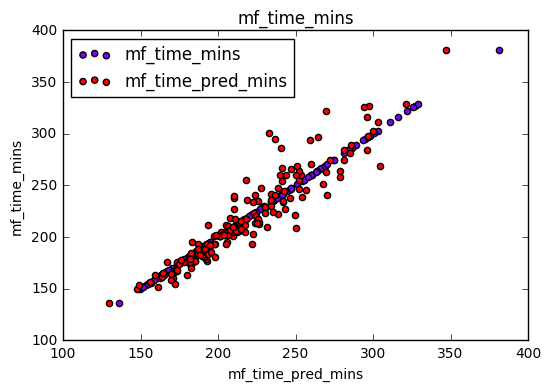

In [207]:
plot_manyx(data_test_poly_, ['mf_time_mins', 'mf_time_pred_mins'], 'mf_time_mins', leg_loc=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ff2c31828>]], dtype=object)

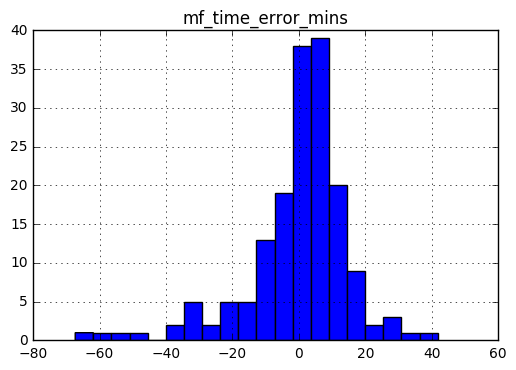

In [183]:
data_test_poly_.hist('mf_time_error_mins', bins=20)

In [193]:
def plot_hist_2(col1, col2, leg1='col1', leg2='col2', title=None, xmin=0, xmax=100, dx=10):

    fig, ax = plt.subplots()

    bins = [bin for bin in range(xmin, xmax, dx)]

    col1_heights, _  = np.histogram(col1, bins=bins)
    col2_heights, _  = np.histogram(col2, bins=bins)

    width = (bins[1] - bins[0])/3

    ax.bar(bins[:-1], col1_heights, width=width, facecolor='cornflowerblue')
    ax.bar([bin + width for bin in bins[:-1]], col2_heights, width=width, facecolor='seagreen')
    plt.legend([leg1, leg2])
    plt.title(title)

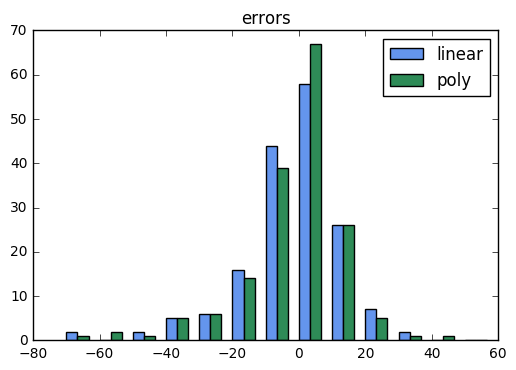

In [192]:
plot_hist_2(data_test_['mf_time_error_mins'], data_test_poly_['mf_time_error_mins'], \
            'linear', 'poly', xmin=-70, xmax=70, dx=10, title='errors')

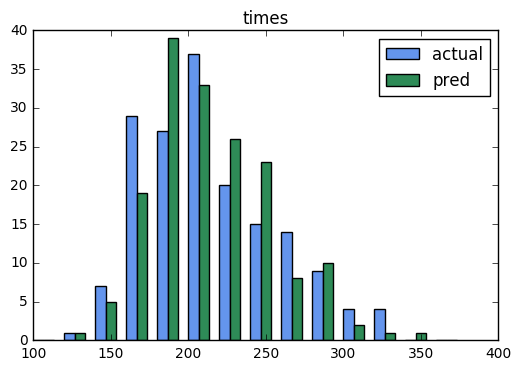

In [197]:
plot_hist_2(data_test_poly_['mf_time_mins'], data_test_poly_['mf_time_pred_mins'], \
            'actual', 'pred', xmin=100, xmax=400, dx=20, title='times')

### Analysis
* linear, poly2 and poly3 are fairly similar, poly2 slight improvement over linear
* ridge best (slightly better than lasso on MAE) at 10.57 minutes MAE train/test
* tree models tend to overfit on train and underperform on test
* no improvement in increasing/decreasing number of features from 50


### Conclusion so far
* I suspect this is close to what can be achieved without race-specific data (starting pace, day-to-day variance, ...)
* the two types of error (slower the expected/bonking and faster than expected) are probably difficult to predict based on mean times of shorter races

### Next steps
* not enough data for more complex models (random forests overfitting)
* consider more expert feature engineering (eg higher power combinations of mean_pace, dist, etc)?
* consider ways to use multiple race data beyond the mean?
* create model learn/inference script once features are finalised
* write up

### Playing with TF

In [ ]:
# Lazily normalise all data together
# Skip for now
#data = data.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

In [ ]:
data.head()

In [ ]:
# Fillna -- this is problematic
data.fillna(value=0, inplace=True)
data.head()

In [ ]:
data.dtypes

In [ ]:
# Cast all columns as floats
data_float = data.astype(float)
data_float.dtypes

In [ ]:
#data_simple = data_float
data_simple = data_float[['k5_s', 'k10_s', 'mh_s', 'k5_di', 'k10_di', 'mh_di', 'k5_tr', 'k10_tr', 'mh_tr', 'mean_s', 'mf_s']]
#data_simple = data_simple[data_simple['mh_s'] > 0]
data_simple.head()

In [ ]:
# Split train and test
np.random.seed(seed = 42)
msk = np.random.rand(len(data_simple)) < 0.7
data_train = data_simple[msk]
data_test = data_simple[~msk]
print(len(data_train))
print(len(data_test))

In [ ]:
# Split into x and y
x_train = data_train.drop('mf_s', axis=1).as_matrix()
y_train = pd.DataFrame(data_train['mf_s']).as_matrix()
(n_train, m) = x_train.shape

x_test = data_test.drop('mf_s', axis=1).as_matrix()
y_test = pd.DataFrame(data_test['mf_s']).as_matrix()
n_test = x_train.shape[0]
print(m)

In [ ]:
# Linear regression model
# Parameters
learning_rate = 0.01
training_epochs = 1000
display_step = 50
batch_size = 100

In [ ]:
# Graph input
x = tf.placeholder(tf.float32, shape=[None, m])
y = tf.placeholder(tf.float32, shape=[None, 1])

# Model weights and bias
w = tf.Variable(tf.zeros([m,1]))
b = tf.Variable(tf.zeros([1]))

# Model
y_ = tf.add(tf.matmul(x,w), b)

In [ ]:
print(x.get_shape)
print(y.get_shape)
print(w.get_shape())
print(b.get_shape())
print(y_.get_shape())
data_train.dtypes






In [ ]:
# Minimize the squared errors.
loss = tf.reduce_mean(tf.square(y_ - y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

In [ ]:
# Initializing the variables
init = tf.initialize_all_variables()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    
    # Train model
    for epoch in range(training_epochs):
        #for (x_t, y_t) in zip(x_train, y_train):
        #print(np.transpose(x_train).shape)
        #print(y_train.shape)
        
        batch_idx = np.random.randint(n_train, size=batch_size)
        x_batch = x_train[batch_idx, :]
        y_batch = y_train[batch_idx, :]


        sess.run(train_step, feed_dict={x: x_batch, y: y_batch})
        
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(loss, feed_dict={x: x_batch, y:y_batch})
            print('Step: ' + str(epoch) + ', loss: ' + str(c))
    
    print('Done')
    loss_train = sess.run(loss, feed_dict={x: x_train, y:y_train})
    print('Train loss: ' + str(loss_train))
    loss_test = sess.run(loss, feed_dict={x: x_test, y:y_test})
    print('Test loss: ' + str(loss_test))
    
    print(w.eval())
    print(b.eval())
    
    y_train_ = sess.run(y_, feed_dict={x:x_train})
    y_test_ = sess.run(y_, feed_dict={x:x_test})
    
    


    


    

In [ ]:
data_train['mf_s_pred'] = y_train_
data_train.head()